In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.learn_deps import DependencyLearner

from metal.label_model.graph_utils import generate_edges
from metal.label_model.graph_utils import JunctionTree
from metal.label_model.graph_utils import DependenciesGraph
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Measure Effective Rank and Spectral Norm

In [2]:
M_list = [5,10,15,20,25,50]
N = 1000 #not used
MAX_CLIQUE_SIZE = 2
NUM_CLIQUES = 1
K = 2
HIGHER_ORDER_CLIQUES = False

spectral_norm = []
effective_rank = []

for M in M_list:
    print(M)
    
    # Set Graph Structure
    EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
    deps_graph = DependenciesGraph(M, EDGES)

    #Generate Data
    data = DataGenerator(
        N,
        M,
        k=K,
        abstains=False,
        deps_graph=deps_graph,
        class_balance=0.5,
        higher_order_cliques=HIGHER_ORDER_CLIQUES
    )
    sigma_O = data.get_sigma_O()
    
    #Calculate norms
    sn = np.linalg.norm(sigma_O,2)
    er = np.trace(sigma_O)/sn
    spectral_norm.append(sn)
    effective_rank.append(er)

5
10
15
20
25
50


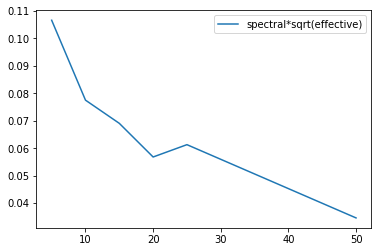

In [3]:
sqrt_thing = [s*np.sqrt(e) for s,e in zip(spectral_norm,effective_rank)]
plt.plot(M_list,[s/(1.0*m) for s,m in zip(sqrt_thing,M_list)])
plt.legend(['spectral*sqrt(effective)'])

## Fred Bound Sanity Check

In [35]:
# Set Graph Structure
N = 1000 #not used
MAX_CLIQUE_SIZE = 3
NUM_CLIQUES = 5
K = 2
HIGHER_ORDER_CLIQUES = False

M = 15
EDGES = generate_edges(M, MAX_CLIQUE_SIZE, NUM_CLIQUES)
deps_graph = DependenciesGraph(M, EDGES)

#Generate Data
data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    class_balance=0.5,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
sigma_O = data.get_sigma_O()

In [36]:
A = np.hstack((data.get_sigma_O(),data.get_sigma_OH()))
B = np.hstack((data.get_sigma_OH().T,data.get_sigma_H()))
sigma_full = np.vstack((A,B))
sigma_full_inv = np.linalg.inv(sigma_full)

K_O = sigma_full_inv[0:M,0:M]
K_OH = sigma_full_inv[-1,0:M]
K_H = sigma_full_inv[-1,-1]

Z = np.linalg.inv(K_O)@K_OH.T
C = 1/(K_H - (K_OH.T@np.linalg.inv(K_O)@K_OH))
sigma_O_est = np.linalg.inv(K_O) + C*np.outer(Z,Z)

print("Sanity: ", np.linalg.norm(sigma_O_est - sigma_O))

Sanity:  1.34990920773501e-16


In [37]:
fred_var = (np.trace(np.linalg.inv(K_O)) - np.trace(C*np.outer(Z,Z)))/np.linalg.norm(sigma_O_est,2)
fred_var

7.180279565291902

In [38]:
sn = np.linalg.norm(sigma_O,2)
er = np.trace(sigma_O)/sn
er

7.449988778607735

In [39]:
fred_bound_numer = np.trace(np.linalg.inv(K_O))+np.linalg.norm(np.sqrt(C)*Z,2)
fred_bound_denom = (1/np.linalg.norm(K_O,2))+np.linalg.norm(np.sqrt(C)*Z,2)
fred_bound_numer/fred_bound_denom

9.840760517668368

In [40]:
(1/np.linalg.norm(K_O,2))

0.08364445095823003

In [41]:
1/(MAX_CLIQUE_SIZE**2)

0.1111111111111111

In [42]:
(MAX_CLIQUE_SIZE**2)*np.trace(np.linalg.inv(K_O))

25.643928720763682